In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading Data

In [8]:
data = pd.read_csv('data/cs-training.csv', index_col=0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [9]:
target_col = 'SeriousDlqin2yrs'

## Splitting into Training and Dev Sets

In [10]:
train = data.sample(n=120000, random_state=3)
dev = data[~data.index.isin(train.index)]
train[target_col].value_counts(normalize=True), dev[target_col].value_counts(normalize=True)

(0    0.933217
 1    0.066783
 Name: SeriousDlqin2yrs, dtype: float64, 0    0.932933
 1    0.067067
 Name: SeriousDlqin2yrs, dtype: float64)

## Cleaning Data

In [11]:
def clean_data(df, income_mv, dependent_mv):
    """
    Imputes missing values
    Floors & ceils the outliers
    Combines smaller categories into a single category
    """
    
    df.columns = [col.replace('-', '_') for col in df.columns]
    
    # RevolvingUtilizationOfUnsecuredLines
    df.loc[df['RevolvingUtilizationOfUnsecuredLines'] >1, 'RevolvingUtilizationOfUnsecuredLines'] = 1
    
    # age
    df.loc[df['age']< 21, 'age'] = 21
    
    # NumberOfTime30-59DaysPastDueNotWorse
    df.loc[df['NumberOfTime30_59DaysPastDueNotWorse']>=2, 'NumberOfTime30_59DaysPastDueNotWorse'] = 2
    
    # NumberOfTime60-89DaysPastDueNotWorse
    df.loc[df['NumberOfTime60_89DaysPastDueNotWorse']>=1, 'NumberOfTime60_89DaysPastDueNotWorse'] = 1
    
    # NumberOfTimes90DaysLate
    df.loc[df['NumberOfTimes90DaysLate']>=1, 'NumberOfTimes90DaysLate'] = 1
    
    # MonthlyIncome
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(income_mv) #replace with median
    
    # NumberOfOpenCreditLinesAndLoans

    # NumberRealEstateLoansOrLines
    df.loc[df['NumberRealEstateLoansOrLines']>=3, 'NumberRealEstateLoansOrLines'] = 3
    
    # NumberOfDependents
    df.loc[df['NumberOfDependents']>=3, 'NumberOfDependents'] = 3
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(dependent_mv) #replace with median
    
    return df



In [12]:
train = clean_data(train, 5400, 0)
dev = clean_data(dev, 5400, 0)

In [13]:
def get_bins_from_training_data(df):
    '''bin variables based on the eda done in the other notebook'''
    binsdf = {}
    _, binsdf['RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df['RevolvingUtilizationOfUnsecuredLines'], 5, retbins=True, labels=None)
    _, binsdf['DebtRatio'] = pd.qcut(df['DebtRatio'], 5, retbins=True, labels=None)
    _, binsdf['age'] = pd.qcut(df['age'], 5, retbins=True, labels=None)
    _, binsdf['MonthlyIncome'] = pd.qcut(df['MonthlyIncome'], 4, retbins=True, labels=None)
    _, binsdf['NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df['NumberOfOpenCreditLinesAndLoans'], 5, retbins=True, labels=None)
    return binsdf

binsdf = get_bins_from_training_data(train)

In [21]:
def create_bins(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], labels=False, include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

def create_bins_2(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

train_binned_df = create_bins(train, binsdf)
dev_binned_df = create_bins(dev, binsdf)

train_binned_df_2 = create_bins_2(train, binsdf)
dev_binned_df_2 = create_bins_2(dev, binsdf)

In [22]:
def weight_of_evidence(df, labelcol, col, categorical_col=None):
    '''calculates weight of evidence values for each category in a given variable (col)'''
    if categorical_col is None:
        categorical_col = col
    
    tempdf = df.groupby(by=categorical_col).agg({labelcol:{
                                                        '_counts': 'size',
                                                        '_bads': lambda x: len(x[x==1]),
                                                        '_goods': lambda x: len(x[x==0])
                                                    }})
    tempdf.columns  = [col+ column for column in tempdf.columns.droplevel(0)]
    tempdf[col+'_distri_tot'] = tempdf[col+'_counts']/(tempdf[col+'_counts'].sum())
    tempdf[col+'_distri_bads'] = tempdf[col+'_bads']/(tempdf[col+'_bads'].sum())
    tempdf[col+'_distri_goods'] = tempdf[col+'_goods']/(tempdf[col+'_goods'].sum())
    tempdf[col+'_bad_rate'] = tempdf[col+'_bads']/tempdf[col+'_counts']
    tempdf[col+'_woe'] = np.log(tempdf[col+'_distri_goods']) - np.log(tempdf[col+'_distri_bads'])
    return tempdf


def information_value(df, col):
    '''calculates Information Value using the Weight of evidence scores'''
    df['diff_col'] = df[col+'_distri_goods'] - df[col+'_distri_bads']
    return np.sum(df['diff_col']*df[col+'_woe'])


In [23]:
def get_woe_from_training_data(binned_df):
    '''calculates the wWeight of Evidence and Information Values based on the training data set for all the features'''
    woe_dict = {}
    iv_dict = {}
    for column in binned_df.columns:
        if column == target_col:
            pass
        else:
            woe_df = weight_of_evidence(binned_df, target_col, column)
            woe_column = [col for col in woe_df.columns if 'woe' in col][0]
            woe_dict[column] = dict(woe_df[woe_column])
            iv_dict[column] = information_value(woe_df, column)
    return woe_dict, iv_dict
 

woe, iv = get_woe_from_training_data(create_bins(train, binsdf))

In [24]:
iv = pd.DataFrame.from_dict(iv, orient='index')
iv.columns = ['information_value']
iv.sort_values(by='information_value', ascending=False)

,information_value
RevolvingUtilizationOfUnsecuredLines,1.051496
NumberOfTimes90DaysLate,0.822086
NumberOfTime30_59DaysPastDueNotWorse,0.736713
NumberOfTime60_89DaysPastDueNotWorse,0.562831
age,0.240657
MonthlyIncome,0.061015
NumberRealEstateLoansOrLines,0.057126
DebtRatio,0.054804
NumberOfOpenCreditLinesAndLoans,0.048957
NumberOfDependents,0.032749


In [25]:
def create_woe(binned_df, woe):
    '''Applies the calculated WoE values on the unseen data set'''
    for column in woe.keys():
        binned_df[column] = binned_df[column].map(woe[column])
    return binned_df


train_woe = create_woe(train_binned_df, woe)
dev_woe =  create_woe(dev_binned_df, woe)

In [26]:
train_woe.columns = [col.replace('-', '_') for col in train_woe.columns]
dev_woe.columns = [col.replace('-', '_') for col in dev_woe.columns]
train_woe.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Model

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
var_cols = [
     'RevolvingUtilizationOfUnsecuredLines',
            'age',
       'NumberOfTime30_59DaysPastDueNotWorse',
            'DebtRatio', 
            'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans',
            'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines',
            'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'
           ]
target_col = 'SeriousDlqin2yrs'

### Fitting the model

In [131]:
sk_model = LogisticRegression()
sk_model.fit(train_woe[var_cols], train_woe[target_col])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
sk_model.coef_

array([[-0.61335402, -0.41623447, -0.53048933, -0.81594201, -0.18261371,
        -0.0077462 , -0.53963422, -0.59939991, -0.40972035, -0.21167682]])

In [133]:
#coefficients

coef = pd.DataFrame()
coef['feature'] = var_cols
coef['coef'] = sk_model.coef_[0]
coef

,feature,coef
0,RevolvingUtilizationOfUnsecuredLines,-0.613354
1,age,-0.416234
2,NumberOfTime30_59DaysPastDueNotWorse,-0.530489
3,DebtRatio,-0.815942
4,MonthlyIncome,-0.182614
5,NumberOfOpenCreditLinesAndLoans,-0.007746
6,NumberOfTimes90DaysLate,-0.539634
7,NumberRealEstateLoansOrLines,-0.599400
8,NumberOfTime60_89DaysPastDueNotWorse,-0.409720
9,NumberOfDependents,-0.211677


In [153]:
# saving model

import pickle as pkl

with open('/home/ydz853/givemesomecredit/model/model_sk_10_variables_1.pkl', 'wb') as f:
    pkl.dump(sk_model, f)

### Checking performance

-----   Training Set Performance   --------

ROC_AUC:  0.8541342075938038
Somersd:  0.7082684151876075


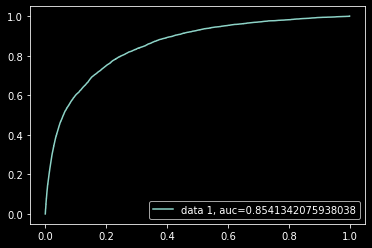

In [135]:
import sklearn.metrics as setrics
plt.style.use('dark_background')

def get_metrics(df, model, var_cols, label_col):
    '''plots roc-auc and calcualtes somers-d score'''
    roc_auc = setrics.roc_auc_score(df[label_col],  model.predict_proba(df[var_cols])[:,1])
    print('ROC_AUC: ', roc_auc)
    
    somersd = 2*roc_auc -1
    print('Somersd: ', somersd)
    
    fpr, tpr, _ = setrics.roc_curve(df[label_col],  model.predict_proba(df[var_cols])[:,1])
    plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

print('-----   Training Set Performance   --------\n')    
get_metrics(train_woe, sk_model, var_cols, label_col='SeriousDlqin2yrs')

-----   Dev Set Performance   --------

ROC_AUC:  0.8623886194020043
Somersd:  0.7247772388040086


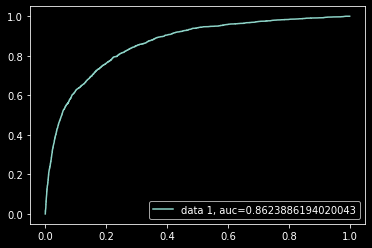

In [136]:
print('-----   Dev Set Performance   --------\n')    

get_metrics(dev_woe.dropna(), sk_model, var_cols, label_col='SeriousDlqin2yrs')

## Scorecard

### Calculating Offset

Let's set the odds of 50:1 at a score of 600

In [137]:
score= 600
odds = 50
pdo = 20
factor = pdo/np.log(2)

offset = score - np.log(odds)*factor
offset

487.1228762045055

In [138]:
def make_scorecard(woe_df, model, features, pdo=20, offset_score=600):
    '''calculates credit score'''
    factor = pdo/np.log(2)
    n = len(features)
    offset = offset_score - np.log(50)*factor
    
    scorecard = -(((woe_df[features]*(model.coef_)).sum(axis=1)) + model.intercept_)*factor +  offset
    return scorecard

In [139]:
train_scorecard = make_scorecard(train_woe, sk_model, var_cols, offset_score=600)
dev_scorecard = make_scorecard(dev_woe, sk_model, var_cols, offset_score=600)

In [140]:
train['credit_score'] = train_scorecard
train.to_csv('output/train_credit_scores.csv')

dev['credit_score'] = dev_scorecard
dev.to_csv('output/dev_credit_scores.csv')

## Predicting on Test Data

In [141]:
test = pd.read_csv('data/cs-test.csv', index_col=0)
test.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [142]:
test = clean_data(test, 5400, 3)
test_binned_df = create_bins(test, binsdf)
test_woe = create_woe(test_binned_df, woe)
test_scorecard = make_scorecard(test_woe, sk_model, var_cols)
test_scorecard.describe()

count    101503.000000
mean        582.466359
std          34.092176
min         427.577870
25%         564.469868
50%         591.859853
75%         608.295013
max         628.477297
dtype: float64

In [143]:
test['credit_score'] = test_scorecard
test.to_csv('output/test_credit_scores.csv')

### Score distribution

In [144]:
dev['credit_score'] = dev_scorecard

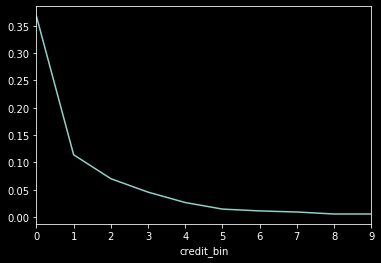

In [145]:
plt.style.use('dark_background')
dev['credit_bin'] = pd.qcut(dev['credit_score'], 10, labels=False)
dev['credit_bin_range'] = pd.qcut(dev['credit_score'], 10)
dev.groupby(by='credit_bin').agg('mean')[target_col].plot()

In [146]:
score_bins = dev.groupby(by='credit_bin_range').agg('mean')[target_col].reset_index()
score_bins.columns =['credit_bin', 'default_rate']
score_bins['default_rate'] = score_bins['default_rate'].round(3).mul(100)
score_bins

,credit_bin,default_rate
0,"(430.72700000000003, 538.407]",36.7
1,"(538.407, 557.485]",11.4
2,"(557.485, 571.319]",7.0
3,"(571.319, 583.019]",4.6
4,"(583.019, 591.464]",2.7
5,"(591.464, 598.953]",1.5
6,"(598.953, 605.154]",1.1
7,"(605.154, 610.533]",0.9
8,"(610.533, 616.912]",0.6
9,"(616.912, 628.477]",0.6


In [147]:
score_bins['min_score'] = score_bins['credit_bin'].apply(lambda x: int(x.left))
score_bins['max_score'] = score_bins['credit_bin'].apply(lambda x: int(x.right))
score_bins = score_bins.reset_index()
score_bins.columns = ['decile', 'credit_bin', 'default_rate', 'min_score', 'max_score']
score_bins = score_bins[['decile', 'credit_bin', 'min_score', 'max_score', 'default_rate']]
score_bins['decile'] = score_bins['decile'] + 1
score_bins

,decile,credit_bin,min_score,max_score,default_rate
0,1,"(430.72700000000003, 538.407]",430,538,36.7
1,2,"(538.407, 557.485]",538,557,11.4
2,3,"(557.485, 571.319]",557,571,7.0
3,4,"(571.319, 583.019]",571,583,4.6
4,5,"(583.019, 591.464]",583,591,2.7
5,6,"(591.464, 598.953]",591,598,1.5
6,7,"(598.953, 605.154]",598,605,1.1
7,8,"(605.154, 610.533]",605,610,0.9
8,9,"(610.533, 616.912]",610,616,0.6
9,10,"(616.912, 628.477]",616,628,0.6


In [148]:
dev_binned_df_3 = dev_binned_df_2.join(dev_woe, rsuffix='_woe')
dev_binned_df_3.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,...,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
7,0,"(0.27, 0.697]","(56.0, 65.0]",0,"(3.62, 329664.0]","(3900.0, 5400.0]","(6.0, 9.0]",0,3,0,...,-0.041499,0.412348,0.538239,0.198680,0.017534,0.230913,0.384389,-0.235988,0.285051,0.145361
9,0,"(0.0828, 0.27]","(20.999, 39.0]",0,"(3.62, 329664.0]","(3900.0, 5400.0]","(-0.001, 4.0]",0,0,0,...,0.856237,-0.491161,0.538239,0.198680,0.017534,-0.351146,0.384389,-0.243963,0.285051,0.145361
13,0,"(-0.001, 0.0191]","(39.0, 48.0]",0,"(0.287, 0.468]","(7373.25, 1794060.0]","(12.0, 57.0]",0,2,0,...,1.300265,-0.238303,0.538239,0.073002,0.368569,0.001339,0.384389,0.206687,0.285051,-0.191095
20,0,"(0.27, 0.697]","(20.999, 39.0]",0,"(-0.001, 0.134]","(-0.001, 3900.0]","(-0.001, 4.0]",0,0,0,...,-0.041499,-0.491161,0.538239,0.093126,-0.328794,-0.351146,0.384389,-0.243963,0.285051,0.145361
25,0,"(0.0191, 0.0828]","(56.0, 65.0]",0,"(0.134, 0.287]","(-0.001, 3900.0]","(6.0, 9.0]",0,1,0,...,1.407820,0.412348,0.538239,0.158030,-0.328794,0.230913,0.384389,0.253011,0.285051,0.145361


### Bin Wise Variable scores

In [149]:
score_list = []
dev_binned_df_3 = dev_binned_df_3.dropna()
for i, variable in enumerate(var_cols):
    for val in dev_binned_df_3[variable+'_woe'].unique():
#         try:
        temp_list = []
        temp_list.append(variable)
        _bin = dev_binned_df_3[dev_binned_df_3[variable+'_woe']==val][variable].mode().values[0]
#             if isinstance(_bin, Interval):
#                 _bin = (_bin.left, _bin.right)
        temp_list.append(_bin)
        temp_list.append((-val*sk_model.coef_[0][i] +\
                                     sk_model.intercept_/len(var_cols))*20/np.log(2) + \
                                    offset/len(var_cols))
        score_list.append(pd.Series(temp_list))
#         except:
#             pass
      

In [150]:
score_df = pd.concat(score_list, axis=1).T
score_df.columns = ['variable', 'bin', 'score']
score_df['left'] = score_df['bin'].apply(lambda x:x if (isinstance(x, np.int64) or isinstance(x, np.float64)) else x.left)
some_df = score_df.sort_values(by=['variable', 'left'], ascending=True).drop(columns=['left'])
# some_df.to_csv('tt.csv')
some_df['score'] = some_df['score'].apply(lambda x: x[0].round(1))
some_df

,variable,bin,score
15,DebtRatio,"(-0.001, 0.134]",43.4
16,DebtRatio,"(0.134, 0.287]",44.9
14,DebtRatio,"(0.287, 0.468]",42.9
17,DebtRatio,"(0.468, 3.62]",31.5
13,DebtRatio,"(3.62, 329664.0]",45.9
20,MonthlyIncome,"(-0.001, 3900.0]",39.4
18,MonthlyIncome,"(3900.0, 5400.0]",41.3
21,MonthlyIncome,"(5400.0, 7373.25]",41.5
19,MonthlyIncome,"(7373.25, 1794060.0]",43.1
35,NumberOfDependents,0,42.1
